## Mount Drive & Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=ca0d06e611b06d89755c68c475ccfa614ad4d2109a18f59f88078a7c908fb6e5
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import opendatasets as od
from google.colab import drive

import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from wordcloud import WordCloud

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
#filepath = '/content/drive/My Drive/ML/Data/Handwriting/' #On Drive 
filepath = '/content/drive/My Drive/MSCA_ML/Final_Project/Data/Handwriting/'
#df_train = pd.read_csv(filepath + 'df_train_with_bb.csv')

### Loading Image

In [ ]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xuetingggg
Your Kaggle Key: ··········


100%|██████████| 1.26G/1.26G [00:06<00:00, 200MB/s]


In [ ]:
file_path_train = '/content/handwriting-recognition/train_v2/train/'
file_path_test = '/content/handwriting-recognition/test_v2/test/'
file_path_valid = '/content/handwriting-recognition/validation_v2/validation/'

In [ ]:
train = pd.read_csv(filepath + 'train.csv')
valid = pd.read_csv(filepath + 'valid.csv')

### Image Shape EDA

In [ ]:
img_filepath = file_path_train

In [ ]:
image_shapes = []
for p in range(len(train)):
    image = cv2.imread(img_filepath + train.iloc[p].FILENAME)
    temp_shape = image.shape
    image_shapes.append(temp_shape)

In [ ]:
df_shape = pd.DataFrame(image_shapes)

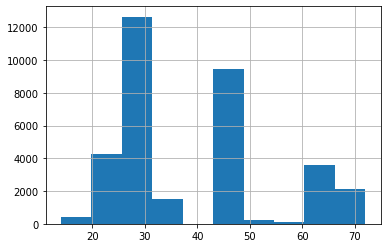

In [ ]:
df_shape[0].hist()

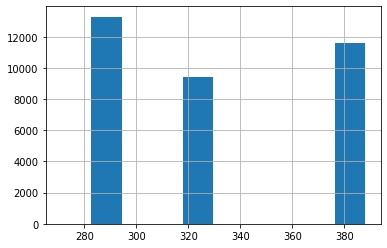

In [ ]:
df_shape[1].hist()

In [ ]:
df_shape.columns = ['height', 'width', 'dim']

In [ ]:
#df_shape.to_csv(filepath + 'df_shape.csv')

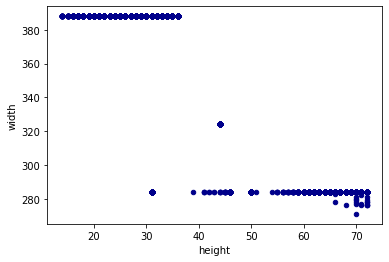

In [ ]:
ax1 = df_shape.plot.scatter(x='height', y='width', c='DarkBlue')

In [ ]:
train_n_shape = train.merge(df_shape, how='inner', left_index=True, right_index = True)

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim
0,TRAIN_00006.jpg,lucie,31,284,3
1,TRAIN_00011.jpg,emma,44,324,3
2,TRAIN_00020.jpg,romain,44,324,3
3,TRAIN_00027.jpg,thomas,44,324,3
4,TRAIN_00069.jpg,ines,23,388,3


### Helper Function get_avg_image

In [ ]:
#Given the filename list, output length and output width, outputs the average image of that name
def get_avg_image(file_list, img_w, img_h):
  
  avg_img = np.zeros((img_h,img_w),float) #Avg image for each name, initialied

  for i in range(len(file_list)):
    name_dir = file_path_train+file_list[i]
    name_img = cv2.imread(name_dir, cv2.IMREAD_GRAYSCALE)
    img_reshape = cv2.resize(name_img, dsize=(img_w, img_h))
    avg_img += img_reshape #accumulator for each name 
    
  avg_img = avg_img/len(file_list)
  return avg_img

#### Clustering with KMeans

Text(0, 0.5, 'WCSS')

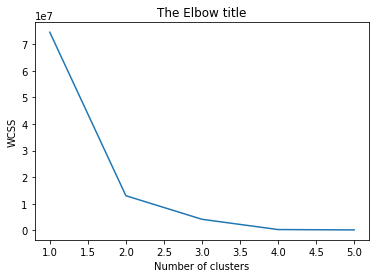

In [ ]:
from sklearn.cluster import KMeans

x = train_n_shape[['height', 'width']]
wcss=[]
for i in range(1,6):
  kmeans = KMeans(i)
  kmeans.fit(x)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,6)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(4)
identified_clusters = kmeans.fit(x)

In [ ]:
identified_clusters.labels_

array([1, 2, 2, ..., 0, 0, 2], dtype=int32)

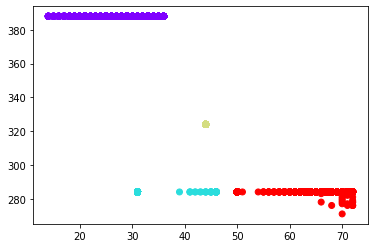

In [ ]:
plt.scatter(train_n_shape['height'],train_n_shape['width'],c=identified_clusters.labels_,cmap='rainbow')

In [ ]:
train_n_shape['km_cluster'] = identified_clusters.labels_

In [ ]:
set(identified_clusters.labels_)

{0, 1, 2, 3}

In [ ]:
kmeans_cluster_avg = [] #acc image for each cluster
for n in range(len(set(identified_clusters.labels_))):
  temp_cluster = np.array(train_n_shape[train_n_shape['km_cluster'] == n].FILENAME)
  temp_max_h = max(train_n_shape[train_n_shape['km_cluster'] == n].height)
  temp_max_w = max(train_n_shape[train_n_shape['km_cluster'] == n].width)
  avg = get_avg_image(temp_cluster, temp_max_w, temp_max_h)
  kmeans_cluster_avg.append(avg)

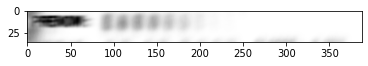

In [ ]:
plt.imshow(kmeans_cluster_avg[0], cmap = 'gray')

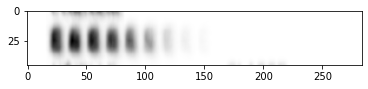

In [ ]:
plt.imshow(kmeans_cluster_avg[1], cmap = 'gray')

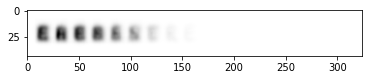

In [ ]:
plt.imshow(kmeans_cluster_avg[2], cmap = 'gray')

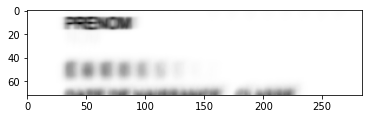

In [ ]:
plt.imshow(kmeans_cluster_avg[3], cmap = 'gray')

##### Boundary Testing

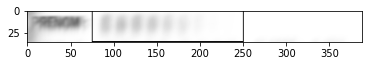

In [ ]:
img0 = kmeans_cluster_avg[0].copy()
cv2.rectangle(img0, (75, 0), (250, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img0, cmap = 'gray')

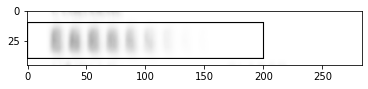

In [ ]:
img1 = kmeans_cluster_avg[1].copy()
cv2.rectangle(img1, (0, 10), (200, 40), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img1, cmap = 'gray')

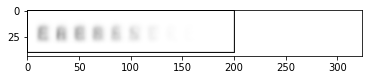

In [ ]:
img2 = kmeans_cluster_avg[2].copy()
cv2.rectangle(img2, (0, 0), (200, 40), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img2, cmap = 'gray')

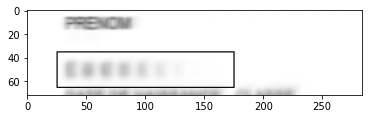

In [ ]:
img3 = kmeans_cluster_avg[3].copy()
cv2.rectangle(img3, (25, 35), (175, 65), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img3, cmap = 'gray')

In [ ]:
kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

In [ ]:
kmeans_boundary_list

[[(75, 0), (250, 35)],
 [(0, 10), (200, 40)],
 [(0, 0), (200, 40)],
 [(25, 35), (175, 65)]]

#### Clustering with DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
x = train_n_shape[['height', 'width']]
clustering = DBSCAN(eps=5, min_samples=2).fit(x)
clustering.labels_

array([0, 1, 1, ..., 2, 2, 1])

In [ ]:
train_n_shape['cluster'] = clustering.labels_

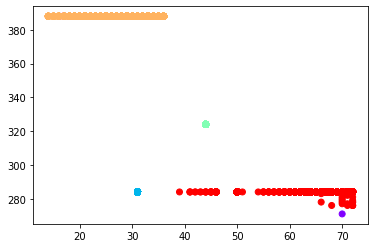

In [ ]:
plt.scatter(train_n_shape['height'],train_n_shape['width'],c=train_n_shape['cluster'],cmap='rainbow')

In [ ]:
set(clustering.labels_)

{-1, 0, 1, 2, 3}

In [ ]:
train_n_shape[train_n_shape['cluster'] == -1]

,FILENAME,IDENTITY,height,width,dim,cluster
7234,TRAIN_70176.jpg,mathis,70,271,3,-1


In [ ]:
train_n_shape[train_n_shape['cluster'] == 1].shape

(9409, 6)

In [ ]:
#train_n_shape.to_csv(filepath + 'train_n_shape.csv')

In [ ]:
cluster_avg = [] #acc image for each cluster
for n in range(-1, 4):
  temp_cluster = np.array(train_n_shape[train_n_shape['cluster'] == n].FILENAME)
  temp_max_h = max(train_n_shape[train_n_shape['cluster'] == n].height)
  temp_max_w = max(train_n_shape[train_n_shape['cluster'] == n].width)
  avg = get_avg_image(temp_cluster, temp_max_w, temp_max_h)
  cluster_avg.append(avg)

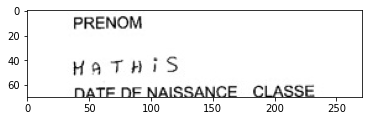

In [ ]:
plt.imshow(cluster_avg[0], cmap = 'gray')

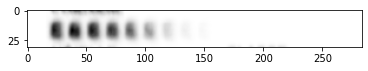

In [ ]:
plt.imshow(cluster_avg[1], cmap = 'gray')

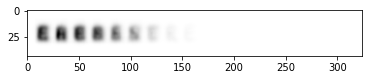

In [ ]:
plt.imshow(cluster_avg[2], cmap = 'gray')

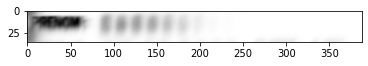

In [ ]:
plt.imshow(cluster_avg[3], cmap = 'gray')

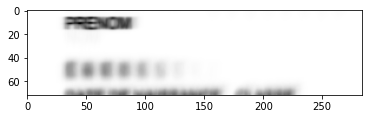

In [ ]:
plt.imshow(cluster_avg[4], cmap = 'gray')

In [ ]:
#train_n_shape.to_csv(filepath + 'train_n_shape.csv')

### Cropping Images and Padding

From the average images we see that we can get five types of images from DBSCAN and four from KMeans by image width and height, and each cluster have a shared type of cropping style and noise in the image. We preprocess our images accordingly.

#### By KMeans

In [ ]:
kmeans_boundary_list = [[(75, 0), (250, 35)], [(0, 10), (200, 40)], [(0, 0), (200, 40)], [(25, 35), (175, 65)]]

##### Image Cropping by KMeans

In [ ]:
total=[]
crop_boxes = []
for i in range(0,len(train)):
  img_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  srcImage = Image.open(img_dir)
  cluster = train_n_shape.loc[i, 'km_cluster']
  image_bx = srcImage.width
  image_by = srcImage.height
  bx = min(kmeans_boundary_list[cluster][1][0], image_bx) 
  by = min(kmeans_boundary_list[cluster][1][1], image_by) #Take image boundary if crop boundary larger than size
  crop_box =  kmeans_boundary_list[cluster][0] + (bx, by)
  crop_boxes.append(crop_box)
  srcImage = srcImage.crop(crop_box)
  srcImage = srcImage.resize((200,35))
  grayImage = srcImage.convert('L')
  binarizedImage = grayImage.point(lambda x: 0 if x<200 else 1, '1')
  pixel = list(binarizedImage.getdata())
  total.append(pixel)

In [ ]:
df_kmeans_cropped = pd.DataFrame(total)

In [ ]:
df_kmeans_cropped['IDENTITY'] = train_n_shape.IDENTITY

In [ ]:
#train_n_shape.to_csv(filepath + 'train_n_shape.csv')
df_kmeans_cropped.to_csv(filepath + 'df_kmeans_cropped.csv')

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,cluster,km_cluster
0,TRAIN_00006.jpg,lucie,31,284,3,0,1
1,TRAIN_00011.jpg,emma,44,324,3,1,2
2,TRAIN_00020.jpg,romain,44,324,3,1,2
3,TRAIN_00027.jpg,thomas,44,324,3,1,2
4,TRAIN_00069.jpg,ines,23,388,3,2,0


#### By DBSCAN

In [ ]:
train_n_shape = pd.read_csv(filepath + 'train_n_shape.csv', index_col = 0)

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,cluster
0,TRAIN_00006.jpg,lucie,31,284,3,0
1,TRAIN_00011.jpg,emma,44,324,3,1
2,TRAIN_00020.jpg,romain,44,324,3,1
3,TRAIN_00027.jpg,thomas,44,324,3,1
4,TRAIN_00069.jpg,ines,23,388,3,2


In [ ]:
train_n_shape.value_counts('cluster')

cluster
 2    11599
 1     9409
 0     7228
 3     6069
-1        1
dtype: int64

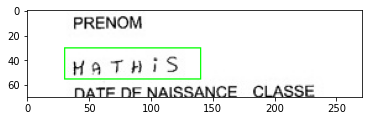

In [ ]:
img_path = file_path_train + 'TRAIN_70176.jpg'
img = cv2.imread(img_path).copy()
cv2.rectangle(img, (30, 30), (140, 55), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img)

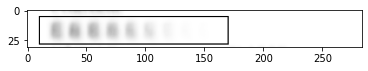

In [ ]:
img0 = cluster_avg[1].copy()
cv2.rectangle(img0, (10, 5), (170, 28), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img0, cmap = 'gray')

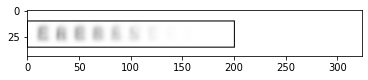

In [ ]:
img1 = cluster_avg[2].copy()
cv2.rectangle(img1, (0, 10), (200, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img1, cmap = 'gray')

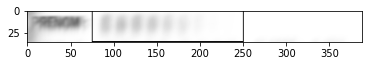

In [ ]:
img2 = cluster_avg[3].copy()
cv2.rectangle(img2, (75, 0), (250, 35), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img2, cmap = 'gray')

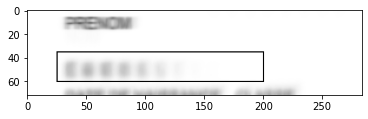

In [ ]:
img3 = cluster_avg[4].copy()
cv2.rectangle(img3, (25, 35), (200, 60), (0,255,0),1) #Second tuple - left up (x, y); third tuple - right bottom (x, y)
plt.imshow(img3, cmap = 'gray')

Through trail and testing we concluded that the cropping boarders for the five clusers can be ([(30, 30), (140, 55)], [(10, 5), (170, 28)], [(0, 10), (200, 35)], [(75, 0), (250, 35)], [(25, 35), (200, 60)])

In [ ]:
boundary_list = [[(30, 30), (140, 55)], [(10, 5), (170, 28)], [(0, 10), (200, 35)], [(75, 0), (250, 35)], [(25, 35), (200, 60)]]

In [ ]:
boundary_list

[[(30, 30), (140, 55)],
 [(10, 5), (170, 28)],
 [(0, 10), (200, 35)],
 [(75, 0), (250, 35)],
 [(25, 35), (200, 60)]]

In [ ]:
#calculate the cropped image size to decide resize for all images
#get the largest bounding box area
max_width = 0
max_height = 0
for i in boundary_list:
  width = i[1][0] - i[0][0]
  height = i[1][1] - i[0][1]
  if max_width < width:
    max_width = width
  if max_height < height:
    max_height = height
print(max_width)
print(max_height)

200
35


##### DBSCAN Image Cropping

In [ ]:
train_n_shape.loc[0, 'cluster']

0

In [ ]:
boundary_list[0][0] + boundary_list[0][1]

(30, 30, 140, 55)

In [ ]:
total=[]
crop_boxes = []
for i in range(0,len(train)):
  img_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  srcImage = Image.open(img_dir)
  cluster = train_n_shape.loc[i, 'cluster']
  image_bx = srcImage.width
  image_by = srcImage.height
  bx = min(boundary_list[cluster+1][1][0], image_bx) 
  by = min(boundary_list[cluster+1][1][1], image_by) #Take image boundary if crop boundary larger than size
  crop_box =  boundary_list[cluster+1][0] + (bx, by)
  crop_boxes.append(crop_box)
  srcImage = srcImage.crop(crop_box)
  srcImage = srcImage.resize((200,35))
  grayImage = srcImage.convert('L')
  binarizedImage = grayImage.point(lambda x: 0 if x<200 else 1, '1')
  pixel = list(binarizedImage.getdata())
  total.append(pixel)

In [ ]:
df_cropped = pd.DataFrame(total)

In [ ]:
df_cropped['IDENTITY'] = train_n_shape.IDENTITY

In [ ]:
train_n_shape['crop_boxes'] = crop_boxes

In [ ]:
train_n_shape.head()

,FILENAME,IDENTITY,height,width,dim,cluster,crop_boxes
0,TRAIN_00006.jpg,lucie,31,284,3,0,"(10, 5, 170, 28)"
1,TRAIN_00011.jpg,emma,44,324,3,1,"(0, 10, 200, 35)"
2,TRAIN_00020.jpg,romain,44,324,3,1,"(0, 10, 200, 35)"
3,TRAIN_00027.jpg,thomas,44,324,3,1,"(0, 10, 200, 35)"
4,TRAIN_00069.jpg,ines,23,388,3,2,"(75, 0, 250, 23)"


In [ ]:
#train_n_shape.to_csv(filepath + 'train_n_shape.csv')

In [ ]:
#df_cropped.to_csv(filepath + 'df_cropped.csv')

### OCR on train

In [ ]:
#!pip install pytesseract 
#!pip install Pillow==9.0.0
#!pip install tesseract
#!sudo apt update
#!sudo apt install tesseract-ocr
#!sudo apt install libtesseract-dev

#########IF WORKING LOCAL ENV#########
#!pip install leptonica #NAH
#!pip install tesseract-ocr #NAH
#brew install tesseract #On Mac

In [ ]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

In [ ]:
train_n_shape = pd.read_csv(filepath + 'train_n_shape.csv', index_col = 0)

In [ ]:
all_text = []
for i in range(train_n_shape.shape[0]):
  org_image_dir =  file_path_train+train_n_shape.loc[i, 'FILENAME']
  org_image = Image.open(org_image_dir)
  crop_dim = crop_boxes[i]
  crop_img = org_image.crop(crop_dim)
  pred_text = pytesseract.image_to_string(crop_img)
  all_text.append(pred_text)

In [ ]:
df_ocr = pd.DataFrame(all_text)

In [ ]:
df_ocr.to_csv(filepath + 'df_ocr.csv')